# Project Week 1                                     <a id="chapter1"></a>
# Table of Contents

* [Project Week 1                                    ](#chapter1)
* [Student details](#chapter2)
* [Project Description                                         ](#chapter3)
* [Data                                    ](#chapter4)
* [Predictive Power of Tie Strength                                    ](#chapter5)
* [Predictive Power of the Number of Open Triades                                    ](#chapter6)
* [Ranking Friends of Friends                                    ](#chapter7)
* [Under construction                          ](#chapter8)


# Student details <a id="chapter2"></a>

Please enter the student numbers and names in the cell below.

Emiel Steegh   - s1846388  
Freek Nijweide - s1857746

# Project Description                                          <a id="chapter3"></a>



Faculty employees at research universities have two major activities: teaching and research. The research is often done in collaboration with colleagues, which results in a joint publication. In this project we will analyse collaborations within the EWI department of the University of Twente based on joint publications. Such investigations are important in order to enhance the research results and applications, and in order to allocate the limited funding to the right research groups and topics.

We represent each researcher as a vertex of a graph. We draw an undirected edge between two vertexes, if the corresponding two researchers have published a joint paper. The resulting graph is called a collaboration graph. We may label each edge as a weak or strong tie depending on the number of joint papers.
In this project we want to verify the following hypotheses:


In this project we want to verify the following hypotheses:

*	The collaborations adhere to the strong triadic closure property: if two researchers A and B both actively collaborate with researcher C, then the chance is high that A and B will collaborate in the future.
*	The large number of open triades, in which two researchers participate, implies that there is a high probability that the two researchers will collaborate in the future.

You task is to explore the given data and make a case whether or not the above hypotheses are true. Additionally, you will have to develop an algorithm that ranks friends of friends by decreasing likelihood of becoming a friend in the future.

In [11]:
# The following includes are needed to work with graphs and display solutions.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from IPython.display import display
from collections import Counter
import utils
import graphs

plt.rcParams["figure.figsize"] = [12,8]

print("imports done")


imports done


# Data                                     <a id="chapter4"></a>
The project is based on the UT collaboration graph. We made snapshots of the UT collaboration graph upto 1995 and upto 2015. The number of publications written by two researchers is noted as the weight of this edge. The following two statements load the collaborations upto these years:

In [3]:
G1995 = utils.fromDot(open('graphs/bib-graph-1995.dot').read())
G2015 = utils.fromDot(open('graphs/bib-graph-2015.dot').read())

print("loading graphs done")

loading graphs done


For example, the researcher 283261 collaborated with researcher 176766, 520454, 617192, 729772, and 797848 and wrote with them 1, 6, 1, 5, and 2 papers respectively. This can be seen as follows:

In [4]:
G1995['283261']

AdjacencyView({'520454': {0: {'weight': '6.000000'}}, '797484': {0: {'weight': '2.000000'}}, '617192': {0: {'weight': '1.000000'}}, '729772': {0: {'weight': '5.000000'}}, '176766': {0: {'weight': '1.000000'}}})

# Predictive Power of Tie Strength                                     <a id="chapter5"></a>

Show that the probability of a new collaboration to be formed in an open triangle A -- B -- C is increasing with the strength of A -- B and B -- C. The tie strength is defined as $\frac{(x+y)}{2}$, where $x$ is the number of collaborations between A and B, and $y$ is the number of collaborations between A and C. The probability is defined as the chance that a new edge has formed between B and C between the G1995 and G2015 graph. You can use the pyplot library (imported as *plt*) to draw a graph to illustrate your answer.


In [99]:
#TODO label the trendline

# BEGIN SOLUTION
def otww(G, mode):
    '''
    Cacluates TieStrength of open node pairs on a triad.
    '''
    
    results = {} #dictionary of format {[tuple node pair]:  float tiestrength}
    
    for n in G.nodes(): #loop through all nodes
        for n1, n2 in [ (n1, n2) for n1 in G[n] for n2 in G[n] if n1 > n2 ]:  #loop over a nodes neighbours
            if n2 not in G[n1]: #as long as n1 and n2 are not connected they are the open ends of a triad
                
                pair = tuple([n1, n2])
                tieStr = (float(G[n][n1][0]['weight']) + float(G[n][n2][0]['weight']))/2 #formula tiestrength = (n-n1 collabs + n-n2 collabs) / 2
                
                if pair not in results:
                    results[pair] = tieStr
                else:
                    if mode == 'ADD': #in adding mode if two nodes are in multiple open triads together the tiestrengths are summed
                        results[pair] += tieStr
                    else: #'MAX' in maximum mode only the highest tiestrength will be considered
                        if (tieStr>results[pair]):
                            results[pair] = tieStr
                        
    return results



def ts_influence(G_new, G_old, mode = 'MAX'):
    '''
    Takes two networks, a new network evolved from the old, and the old network, the mode influences the way tiestrength is calculated
    Grabs TieStrength data and connection probability from two networks and plots it
    '''
    
    if mode != 'ADD' and mode != 'MAX': #make sure the mode is always set to something acceptable
        mode = 'MAX'
        
    pairStrDic = otww(G_old, mode) 
    
    dataraw = {}#dictionary of format {[float unique tiestrength key]:  [float connect average, occurences of that tiestrength]}

    for pair in pairStrDic:
        #for each unique tiestrength get a probability of connection
        keyConnected = False #bool to check wether the in 1995 unconnected pair collaborated in 2015
        if pair[0] in G_new[pair[1]]:keyConnected = True
            
        pairTieStr = pairStrDic[pair]         
    
        if (pairTieStr not in dataraw): #if the unique tiestrength is not in the dict yet add it
            dataraw[pairTieStr] = [0.000,0]
        
        dataraw[pairTieStr][1] += 1 #increase the count of that tiestrength
        #formula to calculate the new succes average (based on the previous average, new addition and count)
        dataraw[pairTieStr][0] = dataraw[pairTieStr][0] + ((int(keyConnected)-dataraw[pairTieStr][0])/dataraw[pairTieStr][1])
    
    #swap the data into a sorted list
    datasorted = []
    for k in dataraw:
        datasorted.append([k, dataraw[k][0],dataraw[k][1]])
    datasorted = sorted(datasorted)
    
    x,y,scale = zip(*datasorted) #zip the list to make a graph
    
    #create a seperate list for scale of each node in the graph based on the ammount of occurences: more data -> more reliable result
    scalemax = sorted(scale, reverse = True)[0]
    ls_scale = []
    for val in scale:
        ls_scale.append(np.interp(val,[1,scalemax],[5,200])) #numpy interp maps a value from one scale onto another

    
    #everything graph make-up related is done below here
    fig,ax = plt.subplots()
    
    plt.title('likelihood of collaborating based on triestrength', fontsize = 18) 
    plt.ylabel('probability of collaboration in an open triangle', fontsize = 14)
    if mode == 'ADD':
        plt.xlabel('sum of all tiestrengths in node pairs on an open triangle', fontsize = 14)
    if mode == 'MAX':
        plt.xlabel('maximum of the tiestrengths of node pairs that exist in one or more open triangles', fontsize = 14)
    
    xmax = sorted(x, reverse = True)[0]
    major_ticksx = np.arange(0,xmax,10)
    minor_ticksx = np.arange(0,xmax,5)
    ax.set_xticks(major_ticksx)
    ax.set_xticks(minor_ticksx, minor = True)
    
    ymax = sorted(y, reverse = True)[0]
    major_ticksy = np.arange(0,ymax,0.2)
    minor_ticksy = np.arange(0,ymax,0.1)
    ax.set_yticks(major_ticksy)
    ax.set_yticks(minor_ticksy, minor = True)
    
    ax.grid(which='major', alpha = 0.6)
    ax.grid(which='minor', alpha = 0.3)
    
    scatter = plt.scatter(x,y, alpha = 0.6, s = ls_scale, c= 'r')
    
    z = np.polyfit(x,y, 1)
    tr = np.poly1d(z)
    trendline = plt.plot(x,tr(x), '--', color = "purple", alpha = 0.8, lw = 1, label = 'Linear trendline')
       
    ax.legend(loc = 'center right', fontsize = 12)
    
    plt.show()

# END SOLUTION    
    
#ts_influence(G2015,G1995,'ADD')
ts_influence(G2015,G1995,'MAX')

print "the size of a mark scales with the ammount of samples there are with the corresponding tiestrength \n larger mark = more data \n"

print "It looks like especially in the lower regions of collaboration based tie strength there is a clear trend. An increase in tiestrength between two researhers that have not yet worked together correlates to a higher chance that the researchers will collaborate in the future."

ValueError: Invalid RGBA argument: 'p'

<Figure size 864x576 with 1 Axes>

the size of a mark scales with the ammount of samples there are with the corresponding tiestrength 
 larger mark = more data 

It looks like especially in the lower regions of collaboration based tie strength there is a clear trend. An increase in tiestrength between two researhers that have not yet worked together correlates to a higher chance that the researchers will collaborate in the future.


# Predictive Power of the Number of Open Triades                                     <a id="chapter6"></a>

Evaluate whether the number of open triades influences the probability that a new collaboration is formed between 1995 and 2015. For example, node B and C do not have an edge, but could be connected by A (one open triad), A and D (two open triades) or even A, D and E (three open triades) and so forth.

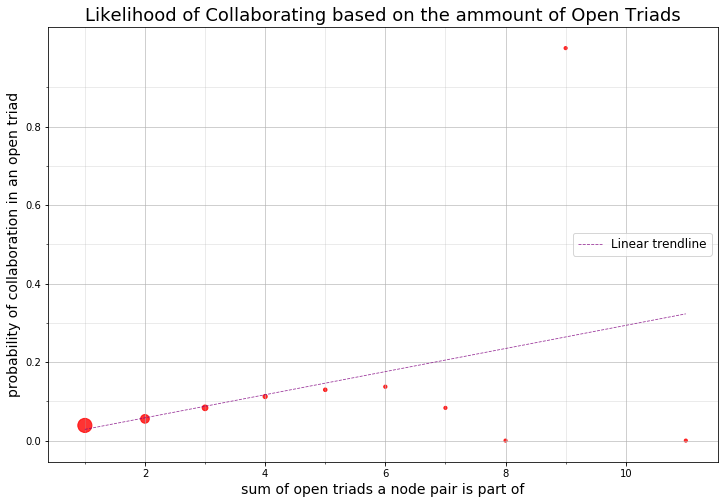

the size of a mark scales with the ammount of samples there are with the corresponding tiestrength 
 larger mark = more data 

uitleg over grafiek


In [98]:
# BEGIN SOLUTION

def otcount(G):
    '''
    Cacluates the ammount of open triads a pair of nodes on the open end are part of.
    '''
    
    results = {}
    for n in G.nodes():
        for n1, n2 in [ (n1, n2) for n1 in G[n] for n2 in G[n] if n1 > n2 ]:  
            if n2 not in G[n1]:
                r = tuple([n1, n2])                
                if r not in results:
                    results[r] = 1
                else:
                    results[r] += 1
                        
    return results


def otc_influence(G_new, G_old):
    pairCountDic = otcount(G_old)
    
    dataraw = {} #dictionary of format {ammount of opentriads : [ended up collabing: did not collab]}
    for pair in pairCountDic:
        #for each count get a probability of connection
        pairConnected = False
        pairTieCount = pairCountDic[pair]
    
        if pair[0] in G_new[pair[1]]:pairConnected = True
    
        if (pairTieCount not in dataraw): #count not yet in dict? add
                dataraw[pairTieCount] = [0.0,0.0]
                
        if pairConnected: #increase the collabed or did not collab rate
            dataraw[pairTieCount][0] += 1
        else:
            dataraw[pairTieCount][1] += 1
            
    ls_CountColAvg = []
    for counts in dataraw:
        total = float(dataraw[counts][0] + dataraw[counts][1])
        avg = float(dataraw[counts][0]) / total
        ls_CountColAvg.append([counts, avg, total])
    ls_CountColAvg.sort()

    x,y,z = zip(*ls_CountColAvg)
        
    scalemax = sorted(z, reverse = True)[0]
    ls_scale = []
    for val in z:
        ls_scale.append(np.interp(val,[1,scalemax],[10,200]))
    
        
    
    fig,ax = plt.subplots()
    
    plt.title('Likelihood of Collaborating based on the ammount of Open Triads', fontsize = 18)
    plt.ylabel('probability of collaboration in an open triad', fontsize = 14)
    plt.xlabel('sum of open triads a node pair is part of', fontsize = 14)
    
    xmax = sorted(x, reverse = True)[0]
    major_ticksx = np.arange(0,xmax,2)
    minor_ticksx = np.arange(0,xmax,1)
    ax.set_xticks(major_ticksx)
    ax.set_xticks(minor_ticksx, minor = True)
    
    ymax = sorted(y, reverse = True)[0]
    major_ticksy = np.arange(0,ymax,0.2)
    minor_ticksy = np.arange(0,ymax,0.1)
    ax.set_yticks(major_ticksy)
    ax.set_yticks(minor_ticksy, minor = True)
    
    ax.grid(which='major', alpha = 0.6)
    ax.grid(which='minor', alpha = 0.3)
    
    scatter = plt.scatter(x,y, alpha = 0.8, s = ls_scale, c= 'r')
    
    z = np.polyfit(x,y, 1)
    tr = np.poly1d(z)
    trendline = plt.plot(x,tr(x), '--', color = "purple", alpha = 0.8, linewidth = 1, label = 'Linear trendline')
        
    ax.legend(loc = 'center right', fontsize = 12)

    plt.show()
        
    
# END SOLUTION

otc_influence(G2015,G1995)

print "the size of a mark scales with the ammount of samples there are with the corresponding tiestrength \n larger mark = more data \n"


print "uitleg over grafiek"

# Ranking Friends of Friends                                     <a id="chapter7"></a>

In this exercise you should apply your knowlege gained from the two previous exercises to answer a common problem in todays social media platforms: given a person, an employee in our case, generate a ranked list of his friends of friends that are likely to become his friends. At the end of the following cell, we provide a code snippet that calculates the precision of your algorithm in predicting future ties in the top-10. 

In [6]:
# employees to test
nodes = ['943855', '587677', '905252', '839906', '554748', '220387', '456096', '136755', '652488', '617192', '154879', '860536', '127930', '266261', '925761', '334823', '879631', '922044', '485657', '347203']
# dictionary mapping an employee to a list of employees with whom he/she collaborated in 2015 and which belonged
# to his friends of friends in 1995. 
result = {'879631': ['587677', '265264', '925761', '860536', '725186', '721127', '142327', '23872', '943855'], '127930': ['26850', '935705', '136755', '659445', '805057', '293364', '681672', '565759', '868762', '596394'], '154879': ['691913', '817338', '659445', '169325', '542646', '644335', '293364', '165240', '485657', '905252', '408618'], '587677': ['879631', '725186', '785747', '70007', '561122', '136755', '721127', '142327', '72828', '334823', '839906', '433369', '943855'], '266261': ['265264', '208388', '70007', '495819', '725186', '839906', '136755', '721127', '142327', '408600'], '860536': ['811970', '879631', '456096', '839906', '396817', '136755', '653075', '72828', '596215', '346572', '922044'], '839906': ['587677', '308351', '860536', '378229', '240448', '379649', '334823', '201753', '565759', '943855', '174262', '922044', '266261'], '347203': ['265464', '578175', '136755', '596215', '220387', '906277', '897180', '652488'], '617192': ['793831', '254964', '522310', '932010', '528813', '922964', '485657', '58492', '694245', '166980', '905252'], '136755': ['811970', '127930', '587677', '266261', '815411', '422460', '860536', '347203', '943855', '691913', '174262', '922044'], '925761': ['879631', '725186', '456096', '70007', '561122', '136803', '596215', '334823', '905252', '943855'], '554748': ['23872', '916957', '659445', '169325', '644335', '293364', '220387', '433369', '943855', '174262', '922044', '652488'], '334823': ['587677', '725186', '785747', '839906', '721127', '142327', '72828', '925761', '943855', '867536'], '220387': ['450166', '571150', '565465', '901612', '554748', '18282', '883925', '347203', '9418', '943855', '265464', '652488'], '485657': ['811970', '154879', '617192', '702341', '41963', '661899', '293364', '668817', '218489'], '905252': ['23872', '742360', '561250', '523695', '222137', '617192', '564846', '925761', '661899', '571150', '154879', '691913', '392536'], '943855': ['265264', '60541', '220387', '14499', '783415', '679997', '811970', '785747', '961828', '587677', '925761', '905502', '561122', '136755', '41963', '554748', '879631', '642974', '725186', '676753', '839906', '213482', '396817', '721127', '576951', '334823', '978812'], '456096': ['206983', '925761', '706765', '860536', '565708', '296067', '902949', '549825', '201753', '961828', '240448', '922044'], '922044': ['456096', '308351', '860536', '839906', '136755', '554748', '433369', '999230', '240448'], '652488': ['602959', '60541', '846007', '143158', '347203', '422460', '14499', '554748', '220387', '265464', '9418']}

def fof(G,n):
    '''
    returns the friends of friends of Node n in Graph G
    '''
    res = set()
    for n1 in G[n]:
        res = res | set(G[n1])
    res = res - set(G[n])
    return res

# BEGIN SOLUTION
# END SOLUTION

def score(n, f):
    '''
    calculates a score by which potential friends should be sorted
    '''
    s = 0
    # BEGIN SOLUTION
    # END SOLUTION
    return s

# Check 
topn = 20

for n in nodes:
    # get all friends of friends and their score
    fofG1995 = fof(G1995, n)
    l = [(f,score(n,f)) for f in fofG1995 ]
    # sort descending by score
    l.sort(key=lambda x: -x[1])
    # count number of correct results
    found = 0
    for x,z in l[:topn]:
        if x in result[n]:
            found += 1            
    print n, found / float(topn)

943855 0.3
587677 0.2
905252 0.15
839906 0.1
554748 0.1
220387 0.1
456096 0.1
136755 0.15
652488 0.15
617192 0.25
154879 0.0
860536 0.15
127930 0.1
266261 0.15
925761 0.0
334823 0.2
879631 0.15
922044 0.1
485657 0.05
347203 0.15


**Explanation: ** Add an explanation of your proposed algorithm here.